In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data.dataset import Subset

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 1048576
# Device configuration (use GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Minimal Working Example

# Data Import

In [2]:
def import_data(root: str, verbose: bool=False) -> datasets.ImageFolder:
    # Load the entire dataset from a single directory
    full_dataset = datasets.ImageFolder(root=root, transform=None)

    # Print the total number of images and class names if verbose=True
    if verbose:
        print(f"Total number of images: {len(full_dataset)}")
        print(f"Number of classes: {len(full_dataset.classes)}")
        print(f"First 5 Classes: {full_dataset.classes[:5]}")
    return full_dataset

full_dataset = import_data('dataset', verbose=True)

Total number of images: 18875
Number of classes: 165
First 5 Classes: ['base1', 'base2', 'base3', 'base4', 'base5']


# Image Transformation

In [3]:
from torchvision.transforms import RandomApply, RandomAffine, RandomPerspective, RandomErasing, GaussianBlur, ColorJitter

# Define a set of augmentations for training
train_transform = transforms.Compose([
    transforms.Resize((342, 245)),  # Resize to a fixed size (adjust based on your model input)
    RandomApply([ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.5),  # Random lighting variations
    RandomApply([GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))], p=0.3),  # Simulate out-of-focus
    RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Simulate different angles with rotation and scaling
    RandomPerspective(distortion_scale=0.2, p=0.3),  # Simulate perspective changes
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert image to tensor
    RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Simulate partial occlusion
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats (adjust if needed)
])

# Define a simpler transform for validation/test (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((342, 245)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Train-val-test Split

In [4]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)


In [5]:
def train_test_split(data: datasets.ImageFolder, val_ratio: float=0.1, test_ratio: float=0.1, batch_size: int=32, train_transform: transforms=None, val_transform: transforms=None, random_state=RANDOM_STATE, verbose: bool=False) -> tuple:
    torch.manual_seed(random_state)

    test_size = int(test_ratio * len(data))
    val_size = int(val_ratio * len(data))
    train_size = len(data) - test_size - val_size

    train_subset, val_subset, test_subset = random_split(data, [train_size, val_size, test_size])

    # Wrap with independent transforms
    train_dataset = TransformSubset(train_subset, transform=train_transform)
    val_dataset = TransformSubset(val_subset, transform=val_transform)
    test_dataset = TransformSubset(test_subset, transform=val_transform)

    if verbose:
        print(f"Training set size: {len(train_dataset)}")
        print(f"Validation set size: {len(val_dataset)}")
        print(f"Test set size: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = train_test_split(full_dataset, batch_size=32, train_transform=train_transform, val_transform=val_transform, random_state=RANDOM_STATE, verbose=True)

Training set size: 15101
Validation set size: 1887
Test set size: 1887


# Visualize the transformations (only works when num_workers=0)

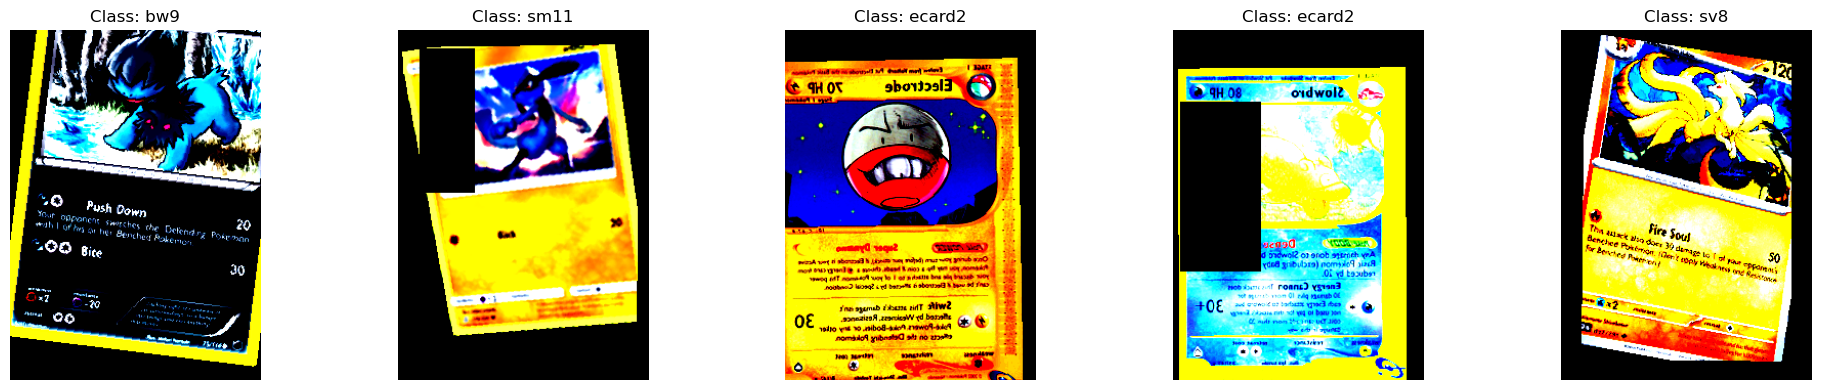

In [6]:
import matplotlib.pyplot as plt

def visualize_augmentations(data_loader, num_samples=5, save_path=None):
    # Grab one batch
    images, labels = next(iter(data_loader))
    
    # Ensure we don't exceed batch size
    num_samples = min(num_samples, len(images))

    class_names = data_loader.dataset.subset.dataset.classes

    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Clip to [0, 1] for display
        label = labels[i].item()
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[label]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
visualize_augmentations(train_loader, num_samples=5)

# Model Building

In [8]:
# Define a ConvBlock class that groups Conv2d, ReLU, and MaxPool2d
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool_size=2, pool_stride=2):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_stride)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply BatchNorm before ReLU
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply BatchNorm before ReLU
        x = self.relu2(x)
        x = self.pool(x)
        return x

In [9]:
# Define the CNN model using multiple ConvBlock layers
class CardAttributeCNN(nn.Module):
    def __init__(self, num_classes):
        super(CardAttributeCNN, self).__init__()
        # Stack 3 ConvBlock layers with increasing channels
        self.block1 = ConvBlock(in_channels=3, out_channels=32)  # Input: 3 (RGB), Output: 32
        self.block2 = ConvBlock(in_channels=32, out_channels=64) # Output: 64
        self.block3 = ConvBlock(in_channels=64, out_channels=128) # Output: 128
        self.block4 = ConvBlock(in_channels=128, out_channels=256) # Output: 256
        # Fully connected layers
        # self.fc1 = nn.Linear(64 * 42 * 30, 128)  # Adjust based on final spatial dimensions after pooling
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)    # Output size = number of classes
        self.dropout = nn.Dropout(0.2)  # Dropout layer for regularization
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling layer
        # Initialize weights for Conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, return_activations=False):
        activations = []
        x = self.block1(x)
        activations.append(x)  # Store activation after block1
        x = self.block2(x)
        activations.append(x)  # Store activation after block2
        x = self.block3(x)
        activations.append(x)  # Store activation after block3
        x = self.block4(x)
        activations.append(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc2(x)
        if return_activations:
            return x, activations
        return x

# Model Training

## Load from checkpoint

In [18]:
# Initialize the model, loss function, and optimizer
num_classes = len(full_dataset.classes)  # Number of classes based on dataset
model = CardAttributeCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.005, steps_per_epoch=len(train_loader), epochs=50)

In [19]:
# Define where your checkpoint is saved
checkpoint_path = "./checkpoints/checkpoint.pth"

# Load checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # scheduler.load_state_dict(checkpoint['scheduler_state_dict']) if 'scheduler_state_dict' in checkpoint else None
    start_epoch = checkpoint['epoch'] + 1  # resume from next epoch
    best_loss = checkpoint['loss']
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch} with val loss {best_loss:.4f}")
else:
    start_epoch = 0
    best_loss = float('inf')
    print("No checkpoint found. Starting from scratch.")

Checkpoint loaded. Resuming from epoch 13 with val loss 60.3846


In [11]:
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, scheduler, epoch, loss, filename="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'loss': loss,
    }, os.path.join(checkpoint_dir, filename))

In [12]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=20, debug=False):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            if debug:
                if batch_count < 10 or (batch_count % 10 == 0 and batch_count <= 100) or (batch_count % 100 == 0):
                    print(f"Batch {batch_count} / {len(train_loader)}, Epoch {start_epoch + epoch+1}")
                batch_count += 1
            optimizer.zero_grad()
            outputs, _ = model(images, True)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Save checkpoint
        save_checkpoint(model, optimizer, scheduler, epoch, val_loss)

        # Print epoch statistics
        print(f'Epoch [{start_epoch + epoch+1}/{start_epoch + num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, debug=True
)

# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

evaluate_model(model, test_loader, criterion)

# Save the model (optional)
torch.save(model.state_dict(), 'base_model_v4.pth')

Batch 0 / 472, Epoch 51
Batch 1 / 472, Epoch 51
Batch 2 / 472, Epoch 51
Batch 3 / 472, Epoch 51
Batch 4 / 472, Epoch 51
Batch 5 / 472, Epoch 51
Batch 6 / 472, Epoch 51
Batch 7 / 472, Epoch 51
Batch 8 / 472, Epoch 51
Batch 9 / 472, Epoch 51
Batch 10 / 472, Epoch 51


c:\Users\User\miniconda3\envs\card-reader\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch 20 / 472, Epoch 51
Batch 30 / 472, Epoch 51
Batch 40 / 472, Epoch 51
Batch 50 / 472, Epoch 51
Batch 60 / 472, Epoch 51
Batch 70 / 472, Epoch 51
Batch 80 / 472, Epoch 51
Batch 90 / 472, Epoch 51
Batch 100 / 472, Epoch 51
Batch 200 / 472, Epoch 51
Batch 300 / 472, Epoch 51
Batch 400 / 472, Epoch 51
Epoch [51/100]
Train Loss: 1.0858, Train Accuracy: 62.79%
Val Loss: 1.0213, Val Accuracy: 67.09%
--------------------------------------------------
Batch 0 / 472, Epoch 52
Batch 1 / 472, Epoch 52
Batch 2 / 472, Epoch 52
Batch 3 / 472, Epoch 52
Batch 4 / 472, Epoch 52
Batch 5 / 472, Epoch 52
Batch 6 / 472, Epoch 52
Batch 7 / 472, Epoch 52
Batch 8 / 472, Epoch 52
Batch 9 / 472, Epoch 52
Batch 10 / 472, Epoch 52
Batch 20 / 472, Epoch 52
Batch 30 / 472, Epoch 52
Batch 40 / 472, Epoch 52
Batch 50 / 472, Epoch 52
Batch 60 / 472, Epoch 52
Batch 70 / 472, Epoch 52
Batch 80 / 472, Epoch 52
Batch 90 / 472, Epoch 52
Batch 100 / 472, Epoch 52
Batch 200 / 472, Epoch 52
Batch 300 / 472, Epoch 52
Batch

KeyboardInterrupt: 

# Model Analysis

## Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    input_count = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        input_count += inputs.size(0)
        if round(input_count / len(val_loader.dataset) * 100) % 10 == 0:
            print(f"Processed {input_count} / {len(val_loader.dataset)} images")

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


c:\Users\User\miniconda3\envs\card-reader\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed 192 / 1887 images
Processed 384 / 1887 images
Processed 1312 / 1887 images
Processed 1504 / 1887 images
Processed 1696 / 1887 images
Processed 1887 / 1887 images


C:\Users\User\AppData\Local\Temp\ipykernel_23756\2506340328.py:5: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


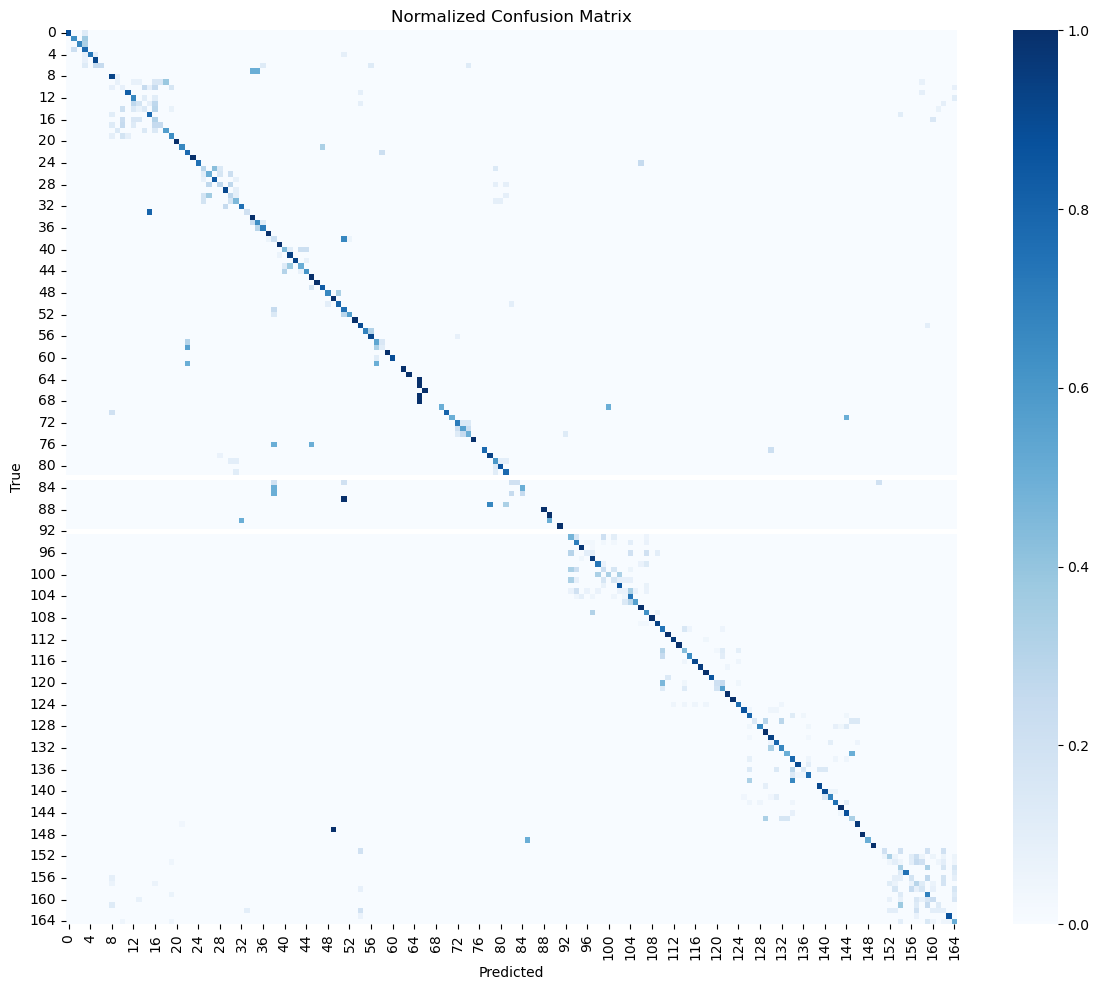

In [25]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

In [37]:
# Copy and zero the diagonal (true positives)
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

top_confusions = np.dstack(np.unravel_index(np.argsort(cm_no_diag.ravel())[::-1], cm.shape))[0]

top_n = 10
for i in range(top_n):
    true_cls, pred_cls = top_confusions[i]
    count = cm[true_cls, pred_cls]
    true_cls_name = full_dataset.classes[true_cls]
    pred_cls_name = full_dataset.classes[pred_cls]
    print(f"True class {true_cls_name} → Predicted as {pred_cls_name} | count = {count}")

True class ex10 → Predicted as ex8 | count = 12
True class sv8 → Predicted as sv1 | count = 11
True class sv4 → Predicted as sv1 | count = 10
True class sv4pt5 → Predicted as sv1 | count = 7
True class gym1 → Predicted as gym2 | count = 6
True class sm3 → Predicted as sm1 | count = 6
True class sv8 → Predicted as sv8pt5 | count = 6
True class sm9 → Predicted as sm12 | count = 5
True class sm6 → Predicted as sm7 | count = 5
True class xy10 → Predicted as xy3 | count = 5


Loaded trained model from base_model_v4.pth
<class 'torch.Tensor'> 38


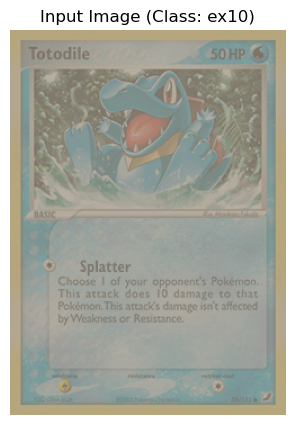

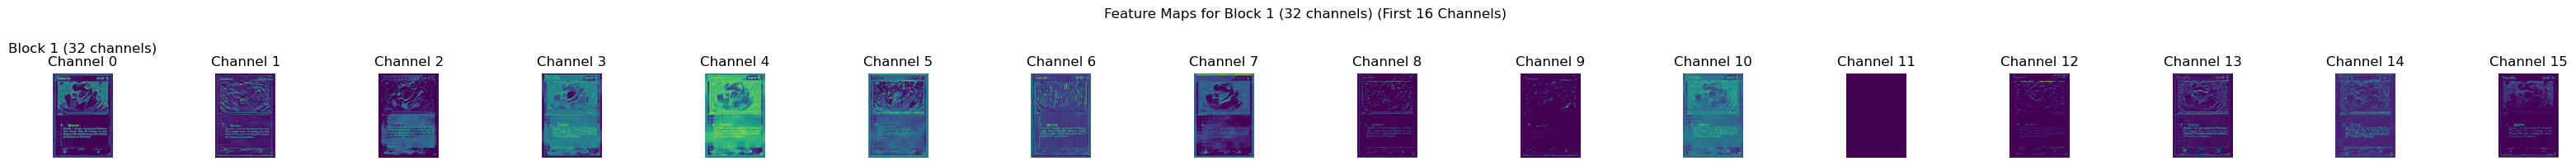

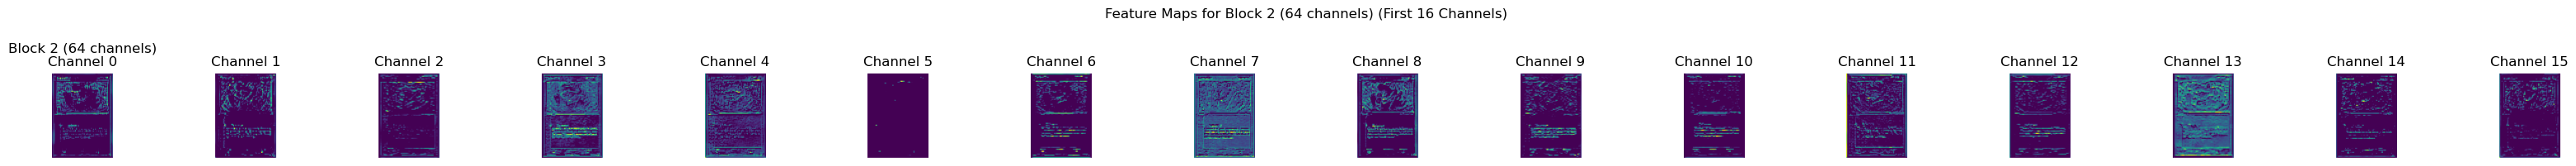

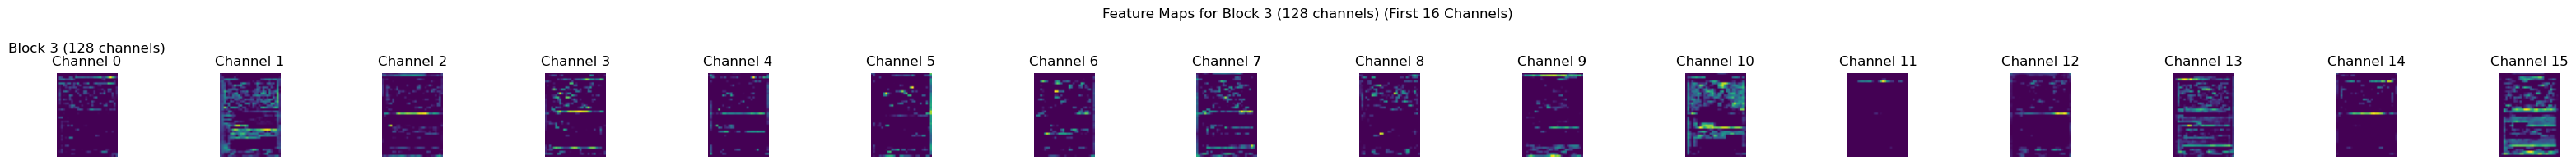

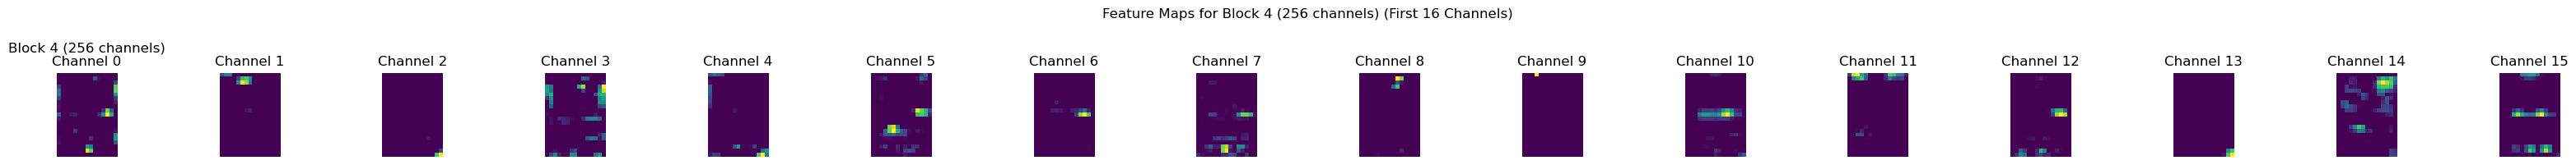

In [38]:
# Initialize the model and load trained weights (if available)
num_classes = len(full_dataset.classes)
model = CardAttributeCNN(num_classes).to(device)
model_path = 'base_model_v4.pth'  # Adjust to your saved model path
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded trained model from {model_path}")
model.eval()  # Set to evaluation mode

# Select a sample image (e.g., first image from the dataset)
sample_image, sample_label = full_dataset[np.random.randint(0, len(full_dataset))]  # You can change the index
sample_image = transforms.Compose([transforms.ToTensor()])(sample_image)
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension
print(type(sample_image), sample_label)

# Reverse normalization for visualizing the input image
unnorm_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
input_img = unnorm_transform(sample_image.squeeze(0).cpu()).permute(1, 2, 0).numpy()
input_img = input_img.clip(0, 1)

# Forward pass to get activations
with torch.no_grad():
    _, activations = model(sample_image, return_activations=True)

# Function to visualize feature maps
def visualize_feature_maps(activations, layer_names, num_channels_to_show=8):
    for layer_idx, (activation, layer_name) in enumerate(zip(activations, layer_names)):
        activation = activation.squeeze(0).cpu().numpy()  # Remove batch dimension, move to CPU
        num_channels = activation.shape[0]  # Number of channels in this layer
        channels_to_show = min(num_channels, num_channels_to_show)  # Limit to num_channels_to_show
        
        # Create a grid of subplots for this layer
        fig, axes = plt.subplots(1, channels_to_show, figsize=(channels_to_show * 2, 2))
        if channels_to_show == 1:
            axes = [axes]  # Ensure axes is iterable if only one channel
        
        for ch in range(channels_to_show):
            # Plot the feature map for this channel
            axes[ch].imshow(activation[ch], cmap='viridis')  # Use 'viridis' or 'gray' colormap
            axes[ch].axis('off')
            if ch == 0:
                axes[ch].set_title(f'{layer_name}\nChannel {ch}')
            else:
                axes[ch].set_title(f'Channel {ch}')
        plt.suptitle(f'Feature Maps for {layer_name} (First {channels_to_show} Channels)')
        plt.tight_layout()
        plt.show()

# Visualize the input image
plt.figure(figsize=(5, 5))
plt.imshow(input_img)
plt.title(f'Input Image (Class: {full_dataset.classes[sample_label]})')
plt.axis('off')
plt.show()

# Visualize feature maps for each ConvBlock
layer_names = ['Block 1 (32 channels)', 'Block 2 (64 channels)', 'Block 3 (128 channels)', 'Block 4 (256 channels)']
visualize_feature_maps(activations, layer_names, num_channels_to_show=16)

1. BATCH NORM
2. Use GenAI to give more transformations to the images to enrich the dataset
3. Can use Hugging Face pytorch-image-model (TIM)